In [1]:
import pandas as pd
import numpy as np
from itertools import product
from ast import literal_eval
import seaborn as sns
import random
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import geopandas as gp
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import Counter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import tqdm
import matplotlib.colors as mcolors

In [2]:
pubs_path="../../data/nf_folder/Data/DerivedData/CleanedRawData/pub.pkl"
region_path="../../data/nf_folder/Data/AdditionalData/cntry_region.xlsx"

In [3]:
pubs_df=pd.read_pickle(pubs_path)
pubs_df.head()

,id,year,dis,type,author,funder,author_distinct,funder_distinct,funded,IntCol,cofund,intfund
0,60694041,2017,9,1,"[Canada, United States]","[United States, United States]","[United States, Canada]",[United States],1,1,0,0
1,48573156,2012,89,1,[France],Not-Funded,[France],Not-Funded,0,0,0,0
2,55323671,2015,89,1,"[France, Chile]","[Chile, Chile, Chile, Chile, Chile]","[Chile, France]",[Chile],1,1,0,0
3,57633115,2016,31,1,"[Switzerland, United States]",[Switzerland],"[Switzerland, United States]",[Switzerland],1,1,0,0
4,64831413,2018,99,1,[China],"[China, China, China, China, China, China]",[China],[China],1,0,0,0


In [4]:
pubs_df[pubs_df.funded==0].shape[0]

5022190

In [4]:
region=pd.read_excel(region_path)
region=region[['cntry','region2']]
region=region.rename(columns={'region2':'region'})
region=region.replace(to_replace={'region':{'EU':'Europe','Other Europe':'Europe'}})
region.head(2)

,cntry,region
0,Algeria,Africa
1,Angola,Africa


### measure and plot the overall funding intensity of countries across continents

In [5]:
funded=pubs_df[['author_distinct','funded']]
funded=funded.explode('author_distinct')
funded=funded.groupby(['author_distinct','funded']).size().reset_index(name='count')
funded=funded.pivot_table(index='author_distinct',columns='funded',values='count')
funded=funded.div(funded.sum(axis=1), axis=0).reset_index()
funded=funded.rename(columns={'author_distinct':'cntry',0:'not',1:'funded'})

In [6]:
funded=funded.merge(region,on='cntry')
funded.head()

,cntry,not,funded,region
0,Afghanistan,0.551378,0.448622,Asia
1,Albania,0.742275,0.257725,Europe
2,Algeria,0.772406,0.227594,Africa
3,Andorra,0.492754,0.507246,Europe
4,Angola,0.400415,0.599585,Africa


In [35]:
def plot_worldmap(ax,basemap, data, plotcolumn, cmap, vmin, vmax,legend_title):
    """plot a basemap and color the country based on the column passed into
    """

    basemap.plot(ax=ax, linewidth=0.25, edgecolor="#8C8C8C", facecolor="#ffffff")
    data.plot(column=plotcolumn, cmap=cmap, vmin=vmin, vmax=vmax, ax=ax)
    ax.axis("off")
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.05)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    clb = fig.colorbar(sm, cax=cax)
    clb.ax.set_title(legend_title)
    return ax

In [36]:
world_geo=gp.read_file("../../data/nf_folder/Data/AdditionalData/world_map_shp/ne_50m_admin_0_countries.shp")
world_geo=world_geo[['WoS','Code','geometry']]
world_geo=world_geo[world_geo.WoS!='Antarctica']
world_geo.head()

,WoS,Code,geometry
0,Zimbabwe,ZWE,"POLYGON ((31.28789 -22.40205, 31.19727 -22.344..."
1,Zambia,ZMB,"POLYGON ((30.39609 -15.64307, 30.25068 -15.643..."
2,Yemen,YEM,"MULTIPOLYGON (((53.08564 16.64839, 52.58145 16..."
3,Vietnam,VNM,"MULTIPOLYGON (((104.06396 10.39082, 104.08301 ..."
4,Venezuela,VEN,"MULTIPOLYGON (((-60.82119 9.13838, -60.94141 9..."


In [9]:
funded[funded.region=='Oceania']['funded'].mean()

0.6923584568954984

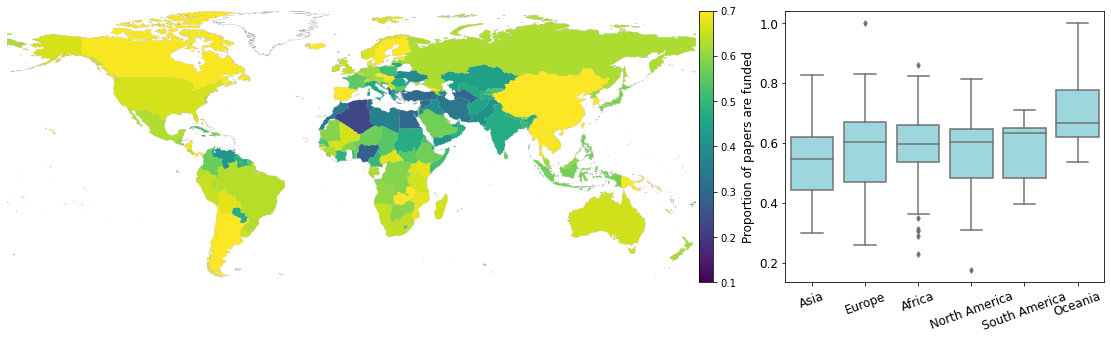

In [11]:
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [70, 30],'wspace': 0.1},figsize=(20,5))
plot_data=world_geo.merge(funded,left_on='WoS',right_on='cntry')
plot_data=gp.GeoDataFrame(plot_data)
plot_worldmap(ax[0],world_geo, plot_data, 'funded','viridis',0.1,0.7,'')
ax[0].margins(0)

sns.boxplot(x='region',y='funded',data=funded,color='#92DFE6',
            order=['Asia','Europe','Africa','North America','South America','Oceania'],
            fliersize=4,
            ax=ax[1])
ax[1].set_ylabel('Proportion of papers are funded',fontsize=12)
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].set_xlabel('')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation = 20)
plt.savefig("/u/miaoli/ember_home/dropbox/NationalFunding/Figs/Figs/funding_intensity_overall.pdf",bbox_inches='tight')

### calculate the funding portofolio of countres

In [4]:
pubs_df.head()

,id,year,dis,type,author,funder,author_distinct,funder_distinct,funded,IntCol,cofund,intfund
0,60694041,2017,9,1,"[Canada, United States]","[United States, United States]","[United States, Canada]",[United States],1,1,0,0
1,48573156,2012,89,1,[France],Not-Funded,[France],Not-Funded,0,0,0,0
2,55323671,2015,89,1,"[France, Chile]","[Chile, Chile, Chile, Chile, Chile]","[Chile, France]",[Chile],1,1,0,0
3,57633115,2016,31,1,"[Switzerland, United States]",[Switzerland],"[Switzerland, United States]",[Switzerland],1,1,0,0
4,64831413,2018,99,1,[China],"[China, China, China, China, China, China]",[China],[China],1,0,0,0


In [5]:
author_df=pubs_df[['id','author_distinct','funder_distinct']].explode('author_distinct')
author_df.head()

,id,author_distinct,funder_distinct
0,60694041,United States,[United States]
0,60694041,Canada,[United States]
1,48573156,France,Not-Funded
2,55323671,Chile,[Chile]
2,55323671,France,[Chile]


In [6]:
region=pd.read_excel(region_path)
region=region[['cntry','region2']]
region=region.rename(columns={'region2':'region'})

In [7]:
eucntrys = region[region.region=='EU'].cntry.values.tolist()

In [8]:
def assign_type(acntry,funders):
    t='null'
    if funders=='Not-Funded':
        t='Not-Funded'
    elif len(funders)==1 and funders[0]==acntry: #if the author country is the only one funder of the pub
        t='Domestic'
    elif acntry in funders:
        t='Co-Fund'
    elif acntry in eucntrys and 'EU' in funders:
        t='Co-Fund'
    elif acntry not in funders:
        t='Foreign'
    return t
author_df['fund']=author_df.apply(lambda x: assign_type(x.author_distinct,x.funder_distinct),axis=1)

In [9]:
fundtype=author_df.groupby(['author_distinct','fund']).size().reset_index(name='count')
fundtype=fundtype.pivot_table(index='author_distinct',columns='fund',values='count',fill_value=0)
fundtype = fundtype.div(fundtype.sum(axis=1), axis=0)
fundtype = fundtype.reset_index().melt(id_vars='author_distinct',var_name='fund', value_name='count')

In [10]:
region=region.replace(to_replace={'region':{'EU':'Europe','Other Europe':'Europe'}})
region.region.unique()

array(['Africa', 'Asia', 'Europe', 'North America', 'South America',
       'Oceania'], dtype=object)

In [11]:
fundtype=fundtype.merge(region,left_on='author_distinct',right_on='cntry',how='left')

In [41]:
fundtype

,author_distinct,fund,count,cntry,region
0,Afghanistan,Co-Fund,0.000000,Afghanistan,Asia
1,Albania,Co-Fund,0.003511,Albania,Europe
2,Algeria,Co-Fund,0.022476,Algeria,Africa
3,Andorra,Co-Fund,0.028986,Andorra,Europe
4,Angola,Co-Fund,0.072614,Angola,Africa
...,...,...,...,...,...
819,Venezuela,Not-Funded,0.583946,Venezuela,South America
820,Vietnam,Not-Funded,0.310601,Vietnam,Asia
821,Yemen,Not-Funded,0.587252,Yemen,Asia
822,Zambia,Not-Funded,0.302500,Zambia,Africa


In [12]:
fundtype=fundtype.dropna()#drop antarctica

In [106]:

def plot_region(df,region,ax,ylabel=0):
    order=['Not-Funded','Domestic','Co-Fund','Foreign']
    palette=['#C5C9C7','#D96C89','#F08987','#EB7549']
    df=df[df.region==region]
    sns.boxplot(data=df,x='count',y='fund',
                order=order,palette=palette,saturation=0.5,width=0.5,
                linewidth=0.6,fliersize=3,ax=ax)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(label=region, fontdict={'fontsize':12})
    ax.set_xticks([])
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xlim(0,1.01)
    if ylabel==0:
        ax.set_yticks([])
    return ax


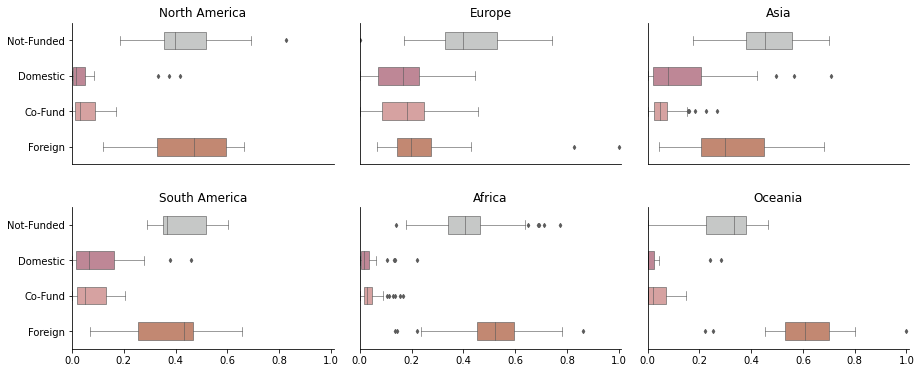

In [108]:
fig,ax=plt.subplots(nrows=2,ncols=3,figsize=(15,6))
plt.subplots_adjust(wspace=0.1,hspace=0.3)

ax0=plot_region(fundtype,'North America',ax[0][0],1)
ax1=plot_region(fundtype,'Europe',ax[0][1])
ax2=plot_region(fundtype,'Asia',ax[0][2])
ax3=plot_region(fundtype,'South America',ax[1][0],1)
ax3.set_xticks(np.arange(0,1.2,0.2))
ax4=plot_region(fundtype,'Africa',ax[1][1])
ax4.set_xticks(np.arange(0,1.2,0.2))
ax5=plot_region(fundtype,'Oceania',ax[1][2])
ax5.set_xticks(np.arange(0,1.2,0.2))
plt.savefig("/u/miaoli/ember_home/dropbox/NationalFunding/Figs/funding_portfolio_region.pdf",bbox_inches='tight')

In [23]:
fundtype

,author_distinct,fund,count,cntry,region
0,Afghanistan,Co-Fund,0.000000,Afghanistan,Asia
1,Albania,Co-Fund,0.003511,Albania,Europe
2,Algeria,Co-Fund,0.022476,Algeria,Africa
3,Andorra,Co-Fund,0.028986,Andorra,Europe
4,Angola,Co-Fund,0.072614,Angola,Africa
...,...,...,...,...,...
819,Venezuela,Not-Funded,0.583946,Venezuela,South America
820,Vietnam,Not-Funded,0.310601,Vietnam,Asia
821,Yemen,Not-Funded,0.587252,Yemen,Asia
822,Zambia,Not-Funded,0.302500,Zambia,Africa


In [29]:
selfund=fundtype.pivot(index=['cntry','region'],columns='fund',values='count').reset_index()
selfund['Funded']=1-selfund['Not-Funded']
selfund['DofF']=selfund['Domestic']/selfund['Funded'] #among the funded papers, the proportion that are exclusively funded by the country

In [30]:
selfund[selfund.cntry=='China']

fund,cntry,region,Co-Fund,Domestic,Foreign,Not-Funded,Funded,DofF
37,China,Asia,0.073513,0.709135,0.043017,0.174335,0.825665,0.858865


In [33]:
selfund['DofF'].max()

0.8588652489532016

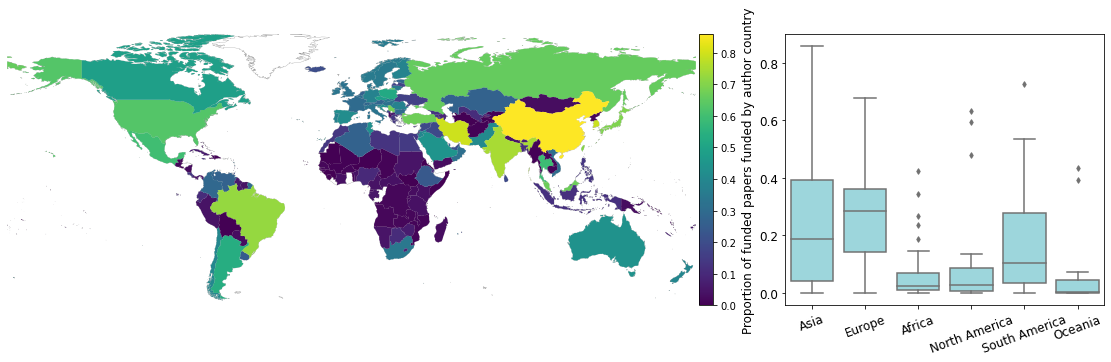

In [40]:
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [70, 30],'wspace': 0.1},figsize=(20,5))
plot_data=world_geo.merge(selfund,left_on='WoS',right_on='cntry')
plot_data=gp.GeoDataFrame(plot_data)
plot_worldmap(ax[0],world_geo, plot_data, 'DofF','viridis',0.0,0.86,'')
ax[0].margins(0)

sns.boxplot(x='region',y='DofF',data=selfund,color='#92DFE6',
            order=['Asia','Europe','Africa','North America','South America','Oceania'],
            fliersize=4,
            ax=ax[1])
ax[1].set_ylabel('Proportion of funded papers funded by author country',fontsize=12)
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].set_xlabel('')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation = 20)
plt.savefig("/u/miaoli/ember_home/dropbox/NationalFunding/Figs/Figs/country_exclusive_funding.pdf",bbox_inches='tight')

,cntry,region,count
195,United States,North America,0.543642


In [118]:
self=fundtype[fundtype.fund.isin(['Co-Fund','Domestic'])]
self=self.pivot(index='cntry',columns='fund',values='count')
self['all']=self['Co-Fund']+self['Domestic']
self=self.reset_index()
self.head()

fund,cntry,Co-Fund,Domestic,all
0,Afghanistan,0.000000,0.002506,0.002506
1,Albania,0.003511,0.007725,0.011236
2,Algeria,0.022476,0.061120,0.083596
3,Andorra,0.028986,0.072464,0.101449
4,Angola,0.072614,0.008299,0.080913


In [126]:
world_geo=gp.read_file("../../data/nf_folder/Data/AdditionalData/world_map_shp/ne_50m_admin_0_countries.shp")

In [127]:
world_geo=gp.read_file("../../data/nf_folder/Data/AdditionalData/world_map_shp/ne_50m_admin_0_countries.shp")
world_geo=world_geo[['WoS','Code','geometry']]
world_geo=world_geo[world_geo.WoS!='Antarctica']
world_geo.head()

,WoS,Code,geometry
0,Zimbabwe,ZWE,"POLYGON ((31.28789 -22.40205, 31.19727 -22.344..."
1,Zambia,ZMB,"POLYGON ((30.39609 -15.64307, 30.25068 -15.643..."
2,Yemen,YEM,"MULTIPOLYGON (((53.08564 16.64839, 52.58145 16..."
3,Vietnam,VNM,"MULTIPOLYGON (((104.06396 10.39082, 104.08301 ..."
4,Venezuela,VEN,"MULTIPOLYGON (((-60.82119 9.13838, -60.94141 9..."


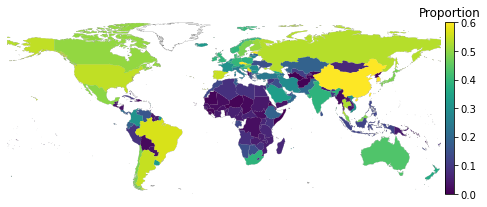

In [138]:
fig,ax= plt.subplots(figsize=(8,6))
plot_data=world_geo.merge(self,left_on='WoS',right_on='cntry')
plot_data=gp.GeoDataFrame(plot_data)
plot_worldmap(ax, fig, world_geo, plot_data, 'all','viridis',0.0,0.6,'Proportion')
ax.margins(0)
plt.savefig('results/funding_intensity_byself.pdf',bbox_inches='tight')

In [134]:
plot_data.sort_values(by='all',ascending=False).head(20)

,WoS,Code,geometry,cntry,Co-Fund,Domestic,all
152,China,CHN,"MULTIPOLYGON (((118.18301 24.49629, 118.14951 ...",China,0.073513,0.709135,0.782648
34,South Korea,KOR,"MULTIPOLYGON (((126.63389 37.78184, 126.66455 ...",South Korea,0.076696,0.565427,0.642123
143,Czech Republic,CZE,"POLYGON ((18.83223 49.51079, 18.80703 49.50923...",Czech Republic,0.252366,0.370534,0.622900
24,Taiwan,TWN,"MULTIPOLYGON (((121.00879 22.62036, 120.94688 ...",Taiwan,0.105693,0.497882,0.603575
134,Estonia,EST,"MULTIPOLYGON (((27.35195 57.52812, 27.32656 57...",Estonia,0.361704,0.227189,0.588893
43,Republic of Serbia,SRB,"POLYGON ((21.36006 44.82666, 21.52314 44.79009...",Republic of Serbia,0.131461,0.444829,0.576290
165,Brazil,BRA,"MULTIPOLYGON (((-66.87603 1.22305, -66.61904 0...",Brazil,0.103905,0.458861,0.562766
33,Spain,ESP,"MULTIPOLYGON (((1.59395 38.67207, 1.57119 38.6...",Spain,0.255283,0.293684,0.548967
180,Argentina,ARG,"MULTIPOLYGON (((-57.60889 -30.18779, -57.64575...",Argentina,0.168737,0.378977,0.547714
55,Portugal,PRT,"MULTIPOLYGON (((-17.19087 32.86860, -17.05449 ...",Portugal,0.277906,0.269069,0.546975


In [9]:
def cal_proportion(df):
    df=df.groupby(['author_distinct','fund']).size().reset_index(name='count')
    df=df.pivot_table(index='author_distinct',columns='fund',values='count',fill_value=0)
    df=df.rename(columns={0:'Not-Fund',1:'Fund'})
    df=df.div(df.sum(axis=1), axis=0)
    df=df.reset_index()
    return df

In [10]:
dome_df=author_df[author_df.IntCol==0]
dome_fund=cal_proportion(dome_df)

In [11]:
coll_fund=author_df[author_df.IntCol==1]
coll_fund=cal_proportion(coll_fund)

In [15]:
region_df=pd.read_excel(region_path)[['cntry','region2']]
region_df.head()

,cntry,region2
0,Algeria,Africa
1,Angola,Africa
2,Belgian Congo,Africa
3,Benin,Africa
4,Botswana,Africa


In [17]:
dome_fund=dome_fund.merge(region_df,left_on='author_distinct',right_on='cntry')
coll_fund=coll_fund.merge(region_df,left_on='author_distinct',right_on='cntry')

In [18]:
dome_fund.head()

,author_distinct,Not-Fund,Fund,cntry,region2
0,Afghanistan,1.000000,0.000000,Afghanistan,Asia
1,Albania,0.995086,0.004914,Albania,Other Europe
2,Algeria,0.918975,0.081025,Algeria,Africa
3,Andorra,1.000000,0.000000,Andorra,Other Europe
4,Angola,1.000000,0.000000,Angola,Africa


<AxesSubplot:xlabel='region2', ylabel='Fund'>

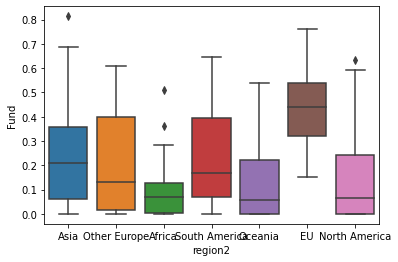

In [19]:
sns.boxplot(x='region2',y='Fund',data=dome_fund)

In [25]:
def plot_worldmap(ax, fig, basemap, data, plotcolumn, cmap, vmin, vmax,legend_title):
    """plot a basemap and color the country based on the column passed into
    """

    basemap.plot(ax=ax, linewidth=0.25, edgecolor="#8C8C8C", facecolor="#ffffff")
    data.plot(column=plotcolumn, cmap=cmap, vmin=vmin, vmax=vmax, ax=ax)
    ax.axis("off")
    
    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes("right", size="2%", pad=0.05)
    #sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    #sm._A = []
    #clb = fig.colorbar(sm, cax=cax)
    #clb.ax.set_title(legend_title)
    return fig, ax

In [26]:
world_geo=gp.read_file("../../data/nf_folder/Data/AdditionalData/world_map_shp/ne_50m_admin_0_countries.shp")

In [27]:
world_geo=gp.read_file("../../data/nf_folder/Data/AdditionalData/world_map_shp/ne_50m_admin_0_countries.shp")
world_geo=world_geo[['WoS','Code','geometry']]
world_geo=world_geo[world_geo.WoS!='Antarctica']
world_geo.head()

,WoS,Code,geometry
0,Zimbabwe,ZWE,"POLYGON ((31.28789 -22.40205, 31.19727 -22.344..."
1,Zambia,ZMB,"POLYGON ((30.39609 -15.64307, 30.25068 -15.643..."
2,Yemen,YEM,"MULTIPOLYGON (((53.08564 16.64839, 52.58145 16..."
3,Vietnam,VNM,"MULTIPOLYGON (((104.06396 10.39082, 104.08301 ..."
4,Venezuela,VEN,"MULTIPOLYGON (((-60.82119 9.13838, -60.94141 9..."


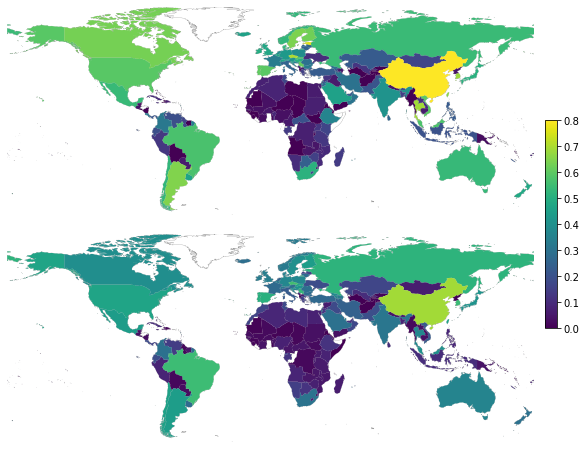

In [38]:
#fig,ax = plt.subplots(1, 3, gridspec_kw={'width_ratios': [4.95,4.95,0.1]},figsize=(20,6))
fig = plt.figure(figsize=(10,8))
gs = fig.add_gridspec(nrows=4, ncols=40)
ax0 = fig.add_subplot(gs[0:2, 0:39])
ax1 = fig.add_subplot(gs[1:3, 39:])
ax2= fig.add_subplot(gs[2:, 0:39])

plot_data=world_geo.merge(dome_fund,left_on='WoS',right_on='author_distinct')
plot_data=gp.GeoDataFrame(plot_data)
plot_worldmap(ax0, fig, world_geo, plot_data, 'Fund','viridis',0.0,0.8,'Proportion')
ax0.margins(0)

plot_data=world_geo.merge(coll_fund,left_on='WoS',right_on='author_distinct')
plot_data=gp.GeoDataFrame(plot_data)
plot_worldmap(ax2, fig, world_geo, plot_data, 'Fund','viridis',0.0,0.8,'Proportion')
ax2.margins(0)

sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=0.8))
fig.colorbar(sm,cax=ax1)
ax1.margins(0)
#ax1.set_title("Proportion of funded publication")
plt.savefig('results/funding_intensity.pdf',bbox_inches='tight')

In [19]:
class MidpointNormalize(mcolors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mcolors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [20]:
def plot_worldmaptest(ax, fig, basemap, data, plotcolumn, cmap, vmin,midpoint, vmax,legend_title):
    """plot a basemap and color the country based on the column passed into
    """
    norm = MidpointNormalize( midpoint = midpoint, vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []

    basemap.plot(ax=ax, linewidth=0.25, edgecolor="#8C8C8C", facecolor="#ffffff")
    data.plot(column=plotcolumn, cmap=cmap, norm=norm, ax=ax)
    ax.axis("off")
    
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.05)
    
    clb = fig.colorbar(sm, cax=cax)
    #clb.ax.set_title(legend_title)
    return fig, ax

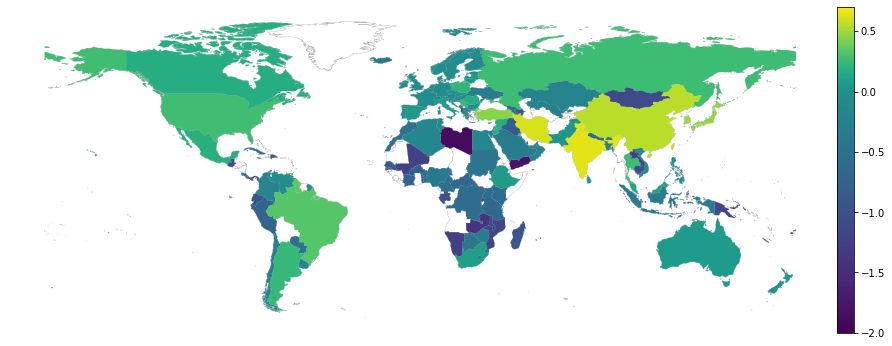

In [8]:
convert_df = pd.read_excel(convert_path)
euset = set(convert_df[convert_df.EU==1].Country.tolist())
def assign_fund(author,funders):
    label=0
    if "EU" in funders and author in euset:
        label = 1
    elif author in funders:
        label=1
    return label
pubs_df['fund']=pubs_df.apply(lambda x:assign_fund(x.author_distinct,x.funder_distinct),axis=1)

,id,author_distinct,funder_distinct,discipline,year,dome_authored
0,30507292,[Turkey],[Turkey],77,2009,1
1,30574690,"[United States, France]",[United States],83,2009,0
2,30574691,[Russia],[Russia],83,2009,1
3,30585095,[Spain],[Spain],89,2009,1
4,30585097,"[Spain, Germany]",[Spain],89,2009,0
